In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from sklearn.preprocessing import MinMaxScaler

import torch
cuda = torch.cuda.is_available()
print("GPU:", cuda)

GPU: True


In [2]:
!python -V

Python 3.7.3


In [3]:
dataset = pd.read_csv("/home/jagadeesh/DS/FB.csv",parse_dates=['Date'],index_col='Date')

In [4]:
dataset.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-05-18,42.049999,45.000000,38.000000,38.230000,38.230000,573576400
2012-05-21,36.529999,36.660000,33.000000,34.029999,34.029999,168192700
2012-05-22,32.610001,33.590000,30.940001,31.000000,31.000000,101786600
2012-05-23,31.370001,32.500000,31.360001,32.000000,32.000000,73600000
2012-05-24,32.950001,33.209999,31.770000,33.029999,33.029999,50237200


In [5]:
def make_dataset(array,time_steps):

    x = []
    y = []

    for i in range(time_steps,len(array)):
        x.append(array[i-time_steps:i])
        y.append(array[i])
        
    return np.array(x), np.array(y)

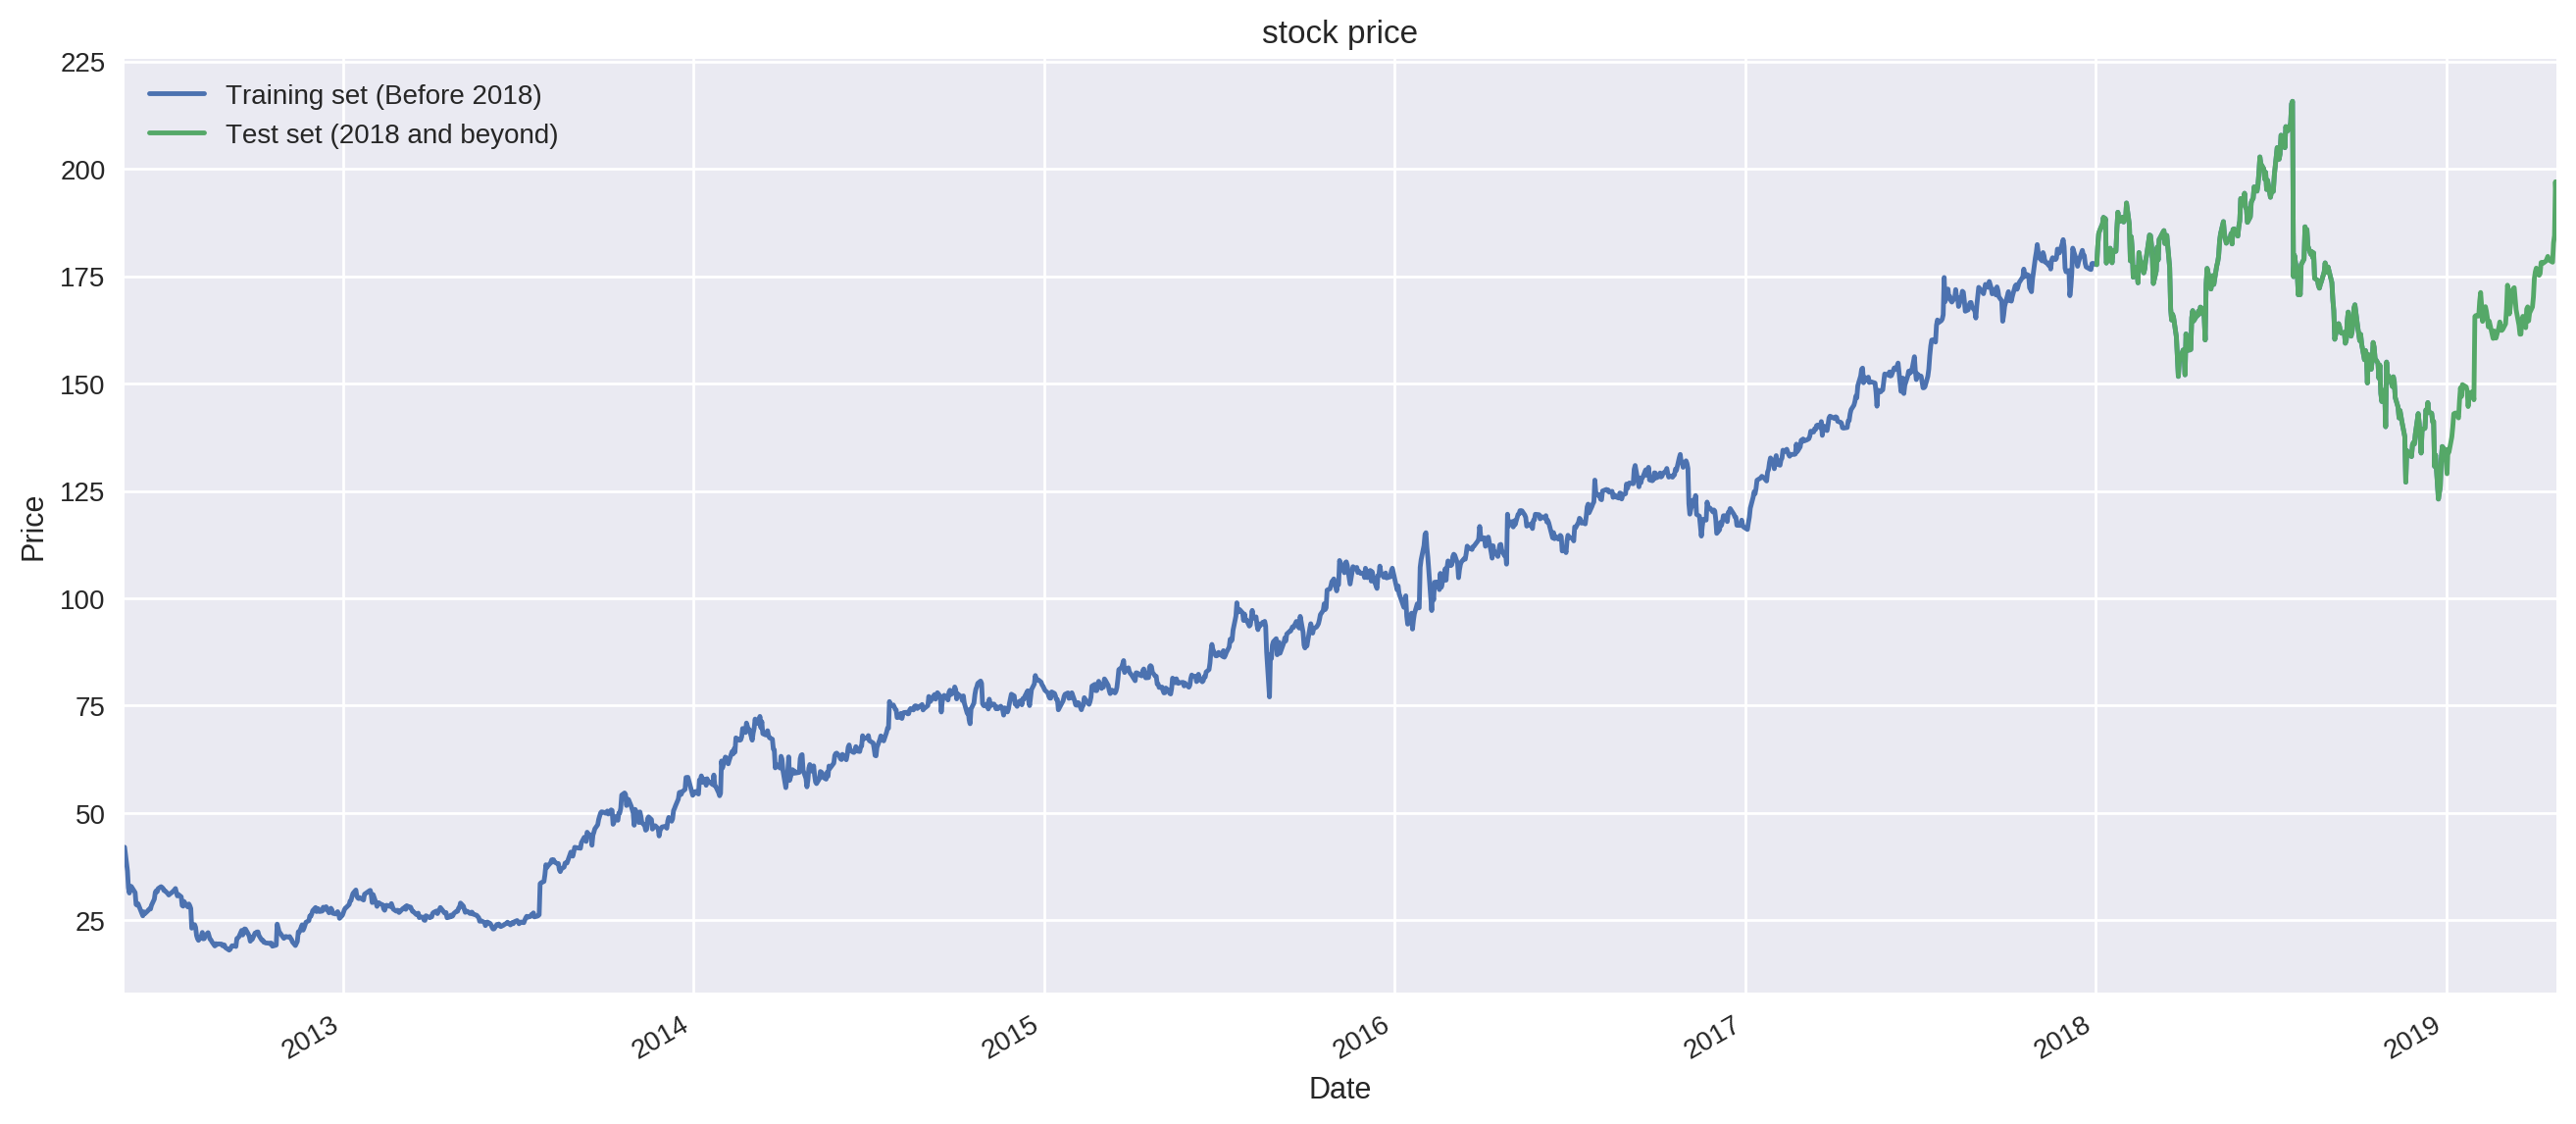

In [6]:
plt.figure(dpi=200,figsize=(16,7))
dataset["Open"][:'2018'].plot(legend=True)
dataset["Open"]['2018':].plot(legend=True)
plt.legend(['Training set (Before 2018)','Test set (2018 and beyond)'])
plt.title('stock price')
plt.ylabel("Price")
plt.show()

In [7]:
train = dataset[:"2018"]["Open"].values


scaler = MinMaxScaler(feature_range=(0,1))
train = scaler.fit_transform(train.reshape(-1,1))

trn_x,trn_y = make_dataset(train,60)

## The three dimensions of this input are:

* **Samples**. One sequence is one sample. A batch is comprised of one or more samples.
* **Time Steps**. One time step is one point of observation in the sample.
* **Features**. One feature is one observation at a time step.

In [8]:
trn_x = trn_x.reshape(-1,60,1)


#covert numpy to torch tensors!
trn_x = torch.from_numpy(trn_x).type(torch.FloatTensor)
trn_y = torch.from_numpy(trn_y).type(torch.FloatTensor)

In [9]:
#load our data into a dataloader object so that we can train our model in batches.

from torch.utils.data import TensorDataset,DataLoader

trn = TensorDataset(trn_x,trn_y)
trn = DataLoader(trn,batch_size=1000)

### Model Architecture

* LSTM(50) x 3 layers with 0.2 Dropout.
* Dense(50,1)

In [10]:
import torch.nn as nn
import torch.nn.functional as F


class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.rnn = nn.LSTM(input_size=1,hidden_size=50,num_layers=3,batch_first=True,dropout=0.2)
        self.out = nn.Linear(50, 1)

    def forward(self, x):

        r_out, (h_n, h_c) = self.rnn(x, None)
        x = r_out[:,-1,:]                    #last hidden output!
        x = self.out(x)
        return x
    
model = Model()

if cuda:
    model.cuda()
    
print(model)

Model(
  (rnn): LSTM(1, 50, num_layers=3, batch_first=True, dropout=0.2)
  (out): Linear(in_features=50, out_features=1, bias=True)
)


In [11]:
from torch.optim import Adam

optimizer = Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [12]:
EPOCHS = 5000

trn_loss = []


model.train()
for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(trn):

        if cuda:
            data,target = data.cuda(),target.cuda()
            
        optimizer.zero_grad()
      
        y_pred = model(data)
        
        loss = loss_fn(y_pred, target)
        loss.backward()
        
        optimizer.step()
        
    #record loss for every epoch!
    trn_loss.append(loss.cpu().data.item())
    if epoch % 100 == 1:
        print("epoch:", epoch+1,"loss:",trn_loss[-1])

epoch: 2 loss: 0.4977755546569824
epoch: 102 loss: 0.002376760123297572
epoch: 202 loss: 0.001669441582635045
epoch: 302 loss: 0.002106432104483247
epoch: 402 loss: 0.0013150254962965846
epoch: 502 loss: 0.0012955485144630075
epoch: 602 loss: 0.0012034325627610087
epoch: 702 loss: 0.001136620296165347
epoch: 802 loss: 0.001055890810675919
epoch: 902 loss: 0.0012217513285577297
epoch: 1002 loss: 0.0010165659477934241
epoch: 1102 loss: 0.0008710204856470227
epoch: 1202 loss: 0.0007953376043587923
epoch: 1302 loss: 0.0007798534934408963
epoch: 1402 loss: 0.0008099462138488889
epoch: 1502 loss: 0.0006395308300852776
epoch: 1602 loss: 0.0006973746349103749
epoch: 1702 loss: 0.0005470882751978934
epoch: 1802 loss: 0.0005224603228271008
epoch: 1902 loss: 0.0004779924056492746
epoch: 2002 loss: 0.000457248417660594
epoch: 2102 loss: 0.0004996199277229607
epoch: 2202 loss: 0.00045037909876555204
epoch: 2302 loss: 0.0009212387376464903
epoch: 2402 loss: 0.0005565090687014163
epoch: 2502 loss: 0.

## Validation

* Test our model on whole data including test set(2018 and beyond)

In [13]:
total = dataset['Open'].values
total_scaled = scaler.transform(total.reshape(-1,1))

total_x,total_y = make_dataset(total_scaled,60)

total_x = torch.from_numpy(total_x).type(torch.FloatTensor)

In [14]:
def predict_with_pytorch(model,val_x):
    model.eval()
    y_preds = []
    
    if cuda:
        val_x = val_x.cuda()
   
    out = model(val_x)
    
    for p in out:
        y_preds.append(p.detach().cpu().numpy().item())
        
        
    return np.array(y_preds).reshape(-1,1)

In [15]:
predicted = predict_with_pytorch(model,total_x)

In [16]:
predicted = scaler.inverse_transform(predicted)

In [17]:
#make a dataset with real and predicted values.

infered = pd.DataFrame(dataset['Open'].iloc[60:])
infered['Open_Predicted'] = predicted

In [18]:
infered.tail()

,Open,Open_Predicted
Date,,
2019-04-22,178.250000,179.922152
2019-04-23,182.740005,179.518184
2019-04-24,184.490005,182.606733
2019-04-25,196.979996,184.519800
2019-04-26,192.500000,193.229313


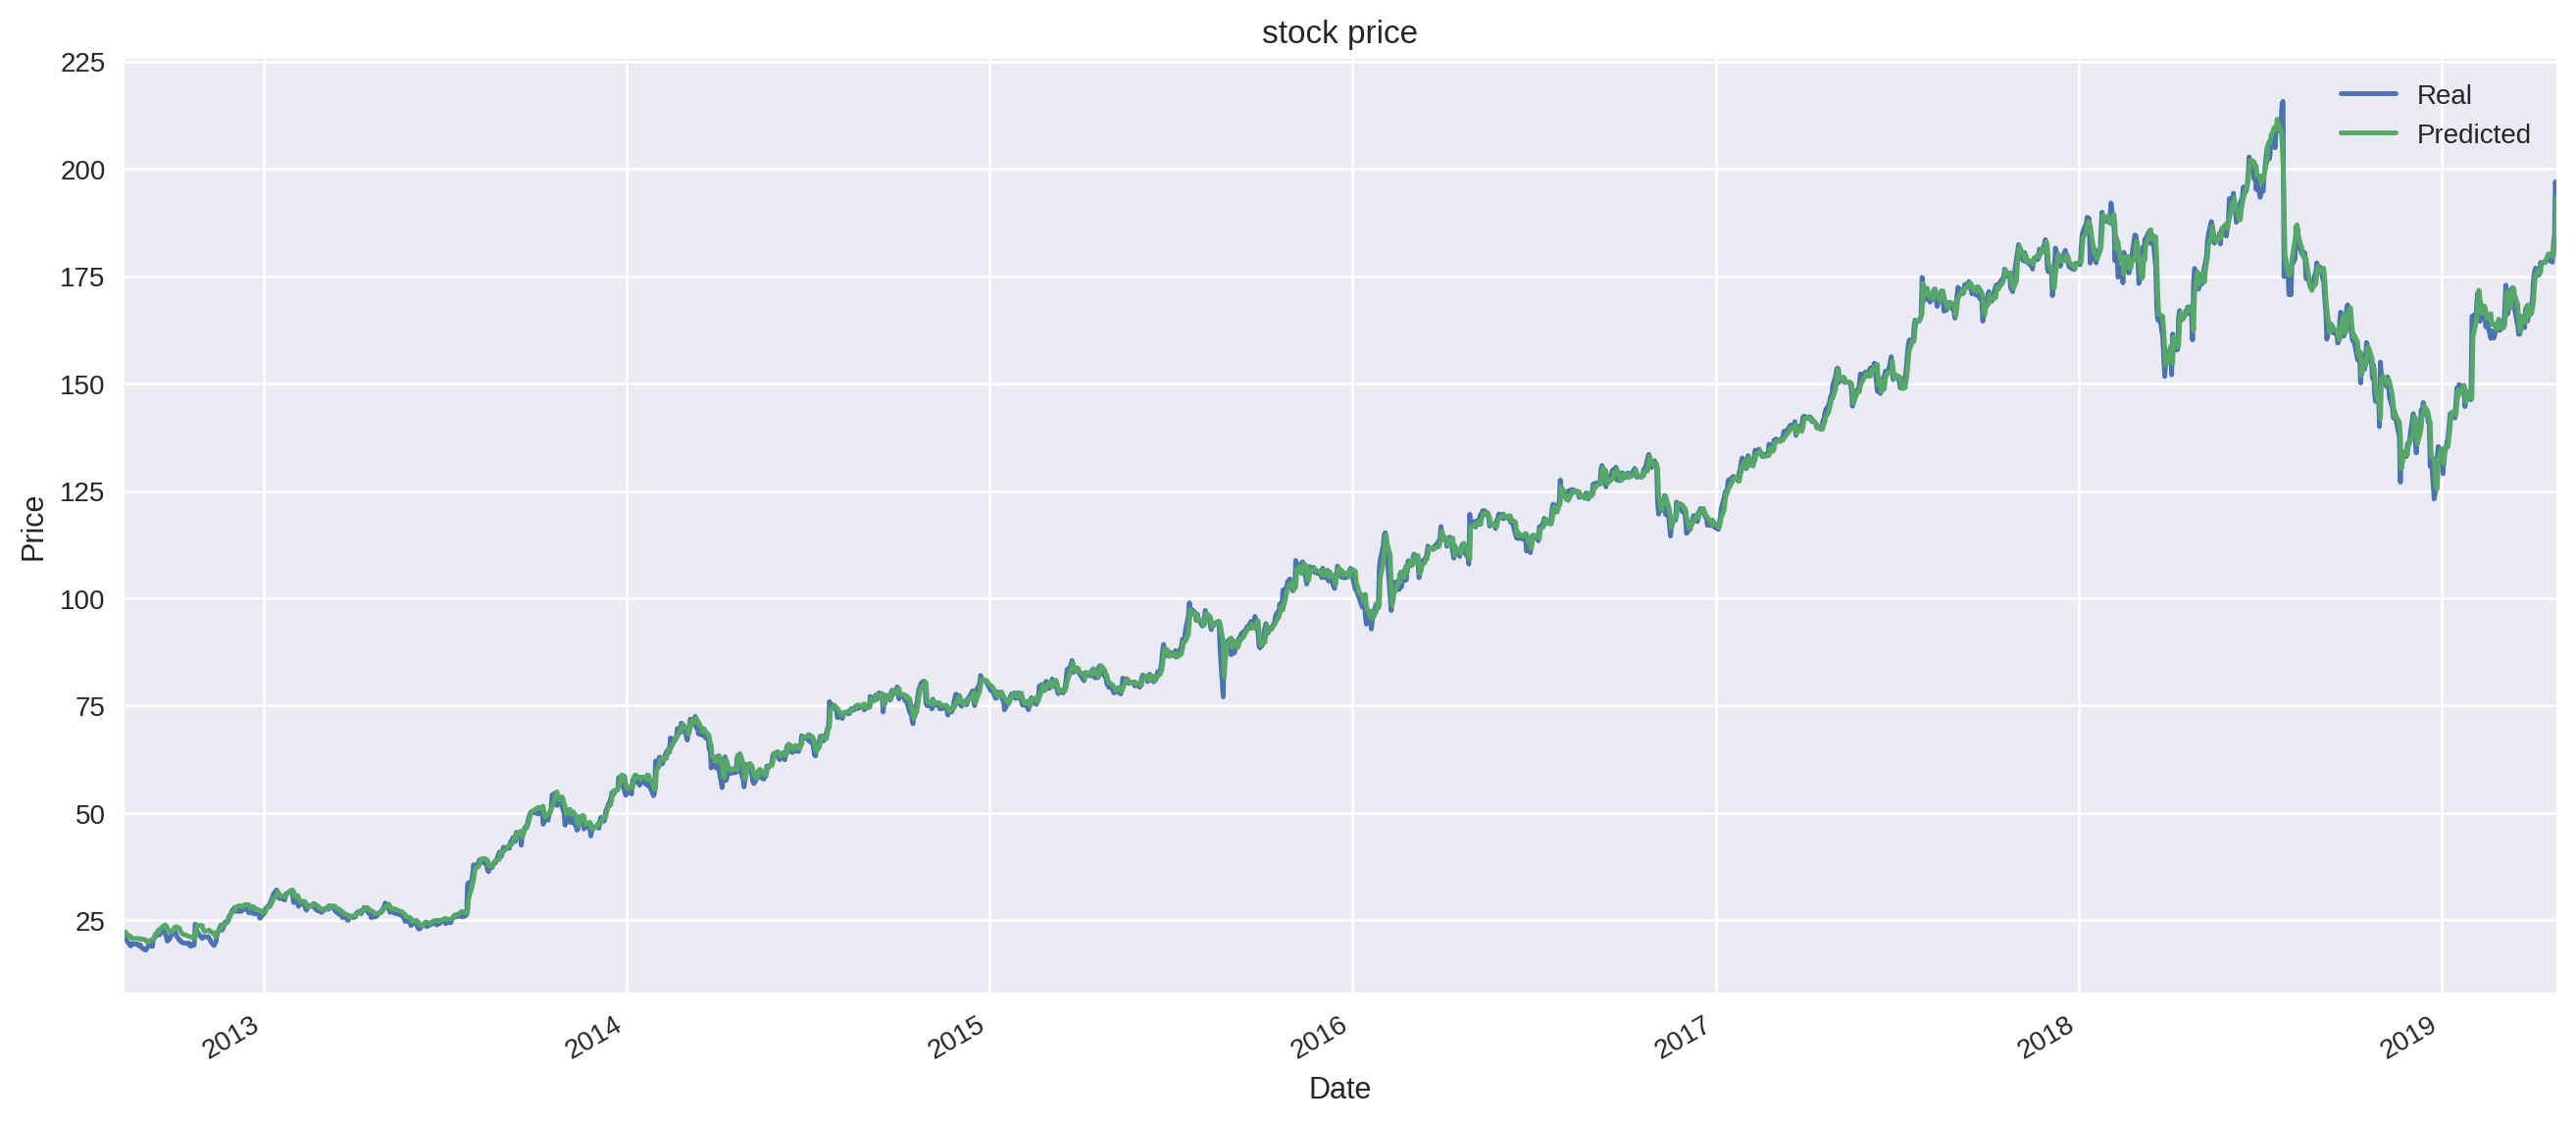

In [19]:
plt.figure(dpi=200,figsize=(16,7))
infered["Open"].plot(legend=True)
infered["Open_Predicted"].plot(legend=True)
plt.legend(['Real','Predicted'])
plt.title('stock price')
plt.ylabel("Price")
plt.show()

In [20]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(dataset['Open'].iloc[60:].values,predicted)
print("RMSE:", np.sqrt(mse))

RMSE: 2.264920639431771
